In [1]:
!pip install bayesian-optimization
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import numpy as np

SEED=0


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [2]:
dataset='Dragon'
data_path = './data/alvaDescDescriptors.txt'
na_values=['na']
df = pd.read_csv(data_path, sep="\t",  dtype={'pctapi': np.float64}, na_values=na_values)
smiles =  np.loadtxt("./data/smiles.txt", dtype='str')
df = df.drop(['No.', 'NAME'], axis=1)
df = df.set_index(smiles)
data_path = './data/master_4Mayhew.xlsx'
df_mor = pd.read_excel(data_path)
y=df_mor['label'] # labels, independent variables
X=df # features, dependent variables
X.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
df.describe()


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,...,865.0,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000
mean,152.497214,8.130482,12.828913,22.149323,13.800939,25.139284,0.597289,1.017789,0.639164,1.143216,...,0.0,0.008478,0.057996,0.191137,2.080402,0.169246,0.417864,0.036698,2.093204,0.600119
std,66.919081,7.112818,5.985939,10.237872,6.521889,11.873281,0.110081,0.072288,0.152502,0.047199,...,0.0,0.152963,0.527725,1.114756,4.437306,0.316773,1.053596,0.089476,4.607502,1.360089
min,16.050000,3.210000,0.910100,1.952700,0.698900,1.856400,0.387050,0.909080,0.349450,0.928200,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106.140000,5.585152,8.778400,15.305400,9.454700,17.079600,0.527400,0.979383,0.576931,1.124658,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,144.240000,6.484286,12.192800,21.283500,13.238800,24.115800,0.571300,0.994537,0.615738,1.138492,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,184.310000,8.068235,15.982800,28.250700,17.307100,31.946200,0.636588,1.019995,0.658200,1.146753,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,532.520000,126.900000,42.281600,67.508700,44.767400,75.820500,1.580200,1.412100,3.039800,1.483150,...,0.0,3.500000,8.500000,12.000000,30.000000,0.913043,7.000000,0.500000,31.304952,9.949874


# Explore the dataset

## How many missing values?

In [3]:
print(f"Number of columns with all NaNs \n{(df.isna().mean(axis=0) == 1).value_counts()}")
print(f"\n Number of columns with >0.9 NaNs \n{(df.isna().mean(axis=0) > 0.9).value_counts()}")
print(f"\n Number of columns with a NaN \n{ len(df.columns[df.isna().any()].tolist())}")

Number of columns with all NaNs 
False    4179
dtype: int64

 Number of columns with >0.9 NaNs 
False    4179
dtype: int64

 Number of columns with a NaN 
1147


### Visualise number of NaNs in descriptors with missing values 

Text(0.5, 0, 'Percentage NaNs in descriptors with missing values')

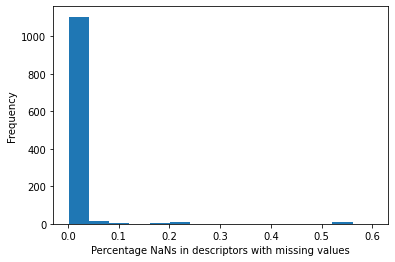

In [4]:
percs = df.isna().mean(axis=0)

ax = percs[(percs > 0)].plot.hist(bins=15)
plt.xlabel("Percentage NaNs in descriptors with missing values")

## Correlation between the descriptors

- degree to which features are related 
- https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

In [5]:
corrs = df.corr()

In [6]:
corrs.to_csv(f'results/correlations/descriptor-correlations-{dataset}.csv')  

### Extract correlation scores for important features

In [7]:
def corrs_important_features(model, X_test, model_name, nlargest=100, heatmap=14):
    feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
    top_100 = feature_imp.nlargest(100)
    important_df = df.loc[:,top_100.index]
    corrs = important_df.corr()
    
    print(f"Extracted correlation scores for most important {nlargest} features for {model_name}")
    corrs.to_csv(f'results/correlations/descriptor-corrs-top{nlargest}-{model_name}-{dataset}.csv')  
    
    # Print heatmap for top n
    print(f"Printing heatmap for most important {heatmap} features")
    
    top_10 = feature_imp.nlargest(heatmap)
    important_df_10 = df.loc[:,top_10.index]
    corrs_10 = important_df_10.corr()
    
    plt.figure(figsize = (16,16))
    heatmap = sns.heatmap(corrs_10, vmin=-1, vmax=1, annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Preprocessing

In [8]:
# Correlation

corrs = df.corr()
# select upper traingle of correlation matrix
upper = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(bool))
# Find index of columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
# drop the columns
df.drop(to_drop, axis=1, inplace=True)

# Remove descriptors with all NaNs 

df.dropna(axis=1, how='all', inplace=True)

In [9]:
df

,MW,AMW,Sv,Se,Mv,Me,Mp,Mi,GD,nSK,...,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_phSize,s34_phRelSize,chiralPhMoment
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,178.15,9.376316,13.4396,19.9600,0.707347,1.050526,0.689589,1.109642,0.179487,13,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C(=C(F)F)(C(F)(F)F)C(F)(F)F,200.04,16.670000,9.1736,15.6360,0.764467,1.303000,0.545467,1.364867,0.166667,12,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],229.12,12.058947,14.0678,21.5965,0.740411,1.136658,0.642032,1.155826,0.133333,16,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,284.76,8.629091,22.7459,33.1562,0.689270,1.004733,0.724006,1.110339,0.115789,20,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C(C(C(F)(F)F)(F)Cl)(F)Cl,202.94,18.449091,8.6787,13.7453,0.788973,1.249573,0.677173,1.295209,0.200000,10,...,0.0,0.0,0,0.0,0.0,0.0,7.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,130.21,5.661304,12.1172,22.8398,0.526835,0.993035,0.575600,1.144574,0.222222,9,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C=CCSS(=O)CC=C,162.30,8.542105,11.7230,18.8981,0.617000,0.994637,0.713521,1.111863,0.222222,9,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCCC(=O)OCC(C)C,144.24,5.547692,13.6440,25.7234,0.524769,0.989362,0.576931,1.143862,0.200000,10,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCCCCOC(=O)CCC,158.27,5.457586,15.1708,28.6070,0.523131,0.986448,0.577986,1.143297,0.181818,11,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # 70% training and 30% test
percentage_odorless = y_train.value_counts()[False]/y_train.shape[0]
percentage_odor = 1 - percentage_odorless
print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 692
Odor: 492
Odorless: 200

Total number molecules in test set: 173
Odor: 123
Odorless: 50

Percentage odorless 0.28901734104046245


### Validation set

In [11]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=SEED)

print("Number of training samples:", len(X_train_t))
print("Number of validation samples:", len(X_val))

Number of training samples: 484
Number of validation samples: 208


## More preprocessing

In [12]:
from sklearn import preprocessing 

# Scale dataset 

min_max_scaler = preprocessing.MinMaxScaler()
X_train_transformed = min_max_scaler.fit_transform(X_train)

X_train =  pd.DataFrame(X_train_transformed, columns=X_train.columns[0:], index=X_train.index)
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns[0:], index=X_test.index)

min_max_scaler2 = preprocessing.MinMaxScaler()
X_train_t_transformed = min_max_scaler2.fit_transform(X_train_t)

X_train_t = pd.DataFrame(X_train_t_transformed, columns=X_train_t.columns[0:], index=X_train_t.index)
X_val = pd.DataFrame(min_max_scaler2.transform(X_val), columns=X_val.columns[0:], index=X_val.index)

X_train

,MW,AMW,Sv,Se,Mv,Me,Mp,Mi,GD,nSK,...,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_phSize,s34_phRelSize,chiralPhMoment
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.289815,0.045038,0.260541,0.247506,0.247052,0.339609,0.103044,0.359004,0.181818,0.314286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCCCCCCCCCCCCCCCO,0.436307,0.003629,0.595244,0.722982,0.076714,0.124074,0.068637,0.386172,0.117647,0.457143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C1(C(O1)(F)F)(C(F)(F)F)F,0.287677,0.100277,0.154810,0.169345,0.296342,0.840089,0.053488,0.758843,0.222222,0.257143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.233333,0.0,0.0,0.174078
CC(C)(C=C)O,0.132420,0.008764,0.173177,0.210394,0.092541,0.158970,0.069547,0.386769,0.333333,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C=CCC1=CC2=C(C=C1)OCO2,0.280233,0.024984,0.312427,0.306912,0.193245,0.199705,0.103599,0.333724,0.196970,0.314286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.140311,0.013900,0.160319,0.191313,0.092203,0.121267,0.089007,0.369162,0.400000,0.114286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCN(CC)CC,0.161710,0.002373,0.230687,0.294928,0.062509,0.124018,0.062688,0.408251,0.285714,0.171429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.319164,0.026780,0.368109,0.332427,0.229208,0.170217,0.122624,0.300973,0.164835,0.371429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
N,0.019436,0.079126,0.006686,0.005603,0.295056,0.531841,0.086998,0.653212,1.000000,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


# Test Model 

In [13]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred))
        
        if hasattr(model, 'feature_importances_') and hasattr(X_test, 'columns'):
            feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
            top_20 = feature_imp.nlargest(20)
            sns.barplot(x=top_20, y=top_20.index)
            plt.xlabel('Descriptor Importance Score')
            plt.ylabel('Descriptor')
            plt.title("Top descriptors")
            plt.show()
        
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs)

In [14]:
def test_model_cross_val(model, y_test, X_test, k=5, verbose=True):
    roc_auc_nans = cross_val_score(model, X_test, y_test, cv=k, scoring='roc_auc')
    print(f"AVERAGE CV={k} ROC_AUC: {np.mean(roc_auc_nans)}")
    print(f"AVERAGE CV={k} STD: {np.std(roc_auc_nans)}")
    return np.mean(roc_auc_nans), np.std(roc_auc_nans)

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [15]:
def handle_importance(model, X_train, X_test=pd.DataFrame(), threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    
    if not X_test.empty:
        X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, model 

In [16]:
def optimiseImportance(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    
    imp_params = [
              {"threshold":-1, 'n':1},
              {"threshold":-1, 'n':2},
              {"threshold":-1, 'n':5}, 
              {"threshold":-1, 'n':10}, 
              {"threshold":-1, 'n':25}, 
              {"threshold":-1, 'n':50},
              {"threshold":-1, 'n':100}, 
              {"threshold":-1, 'n':200}, 
              {"threshold":-1, 'n':400},
              {"threshold":-1, 'n':X_tr.shape[1]}]
    
    sns.set(rc={'figure.figsize':(11.7,12.27)})
    feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
    top_50 = feature_imp.nlargest(50)
    sns.barplot(x=top_50, y=top_50.index)
    plt.xlabel('Descriptor Importance Score')
    plt.ylabel('Descriptor')
    plt.title("Top 50 descriptors")
    plt.show()

    print(f"Cross validated importance experiment with k={k}")
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
        
        X_tr_temp , _, _ = handle_importance(model, 
                                            X_tr.copy(), 
                                            threshold=imp_param['threshold'], 
                                            n=imp_param['n'])
                
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar", x="Most important N descriptors", y="Average AUROC", 
                          yerr="Standard Deviation", 
                          figsize=(8,5),
                          title=f"AUROC after filtering descriptors by importance CV={k} - {model_name} - {dataset}", legend=False)
        plt.ylim(0.80,1)
    return imp_df

In [17]:
def testWithoutImportantDescs(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    imp_params = [
                  {"threshold":-1, 'n':5}, 
                  {"threshold":-1, 'n':10}, 
                  {"threshold":-1, 'n':25}, 
                  {"threshold":-1, 'n':50},
                  {"threshold":-1, 'n':100}, 
                  {"threshold":-1, 'n':200}, 
                  {"threshold":-1, 'n':400}]
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    roc_auc, std = test_model_cross_val(model, y_tr, X_tr)
    imp_df = imp_df.append({'Most important N descriptors': 0, 
                       'Average AUROC':roc_auc, 
                       'Standard Deviation':std}, 
                        ignore_index = True)

    
    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}")

        feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
        feature_imp = feature_imp.nlargest(imp_param['n'])
        X_tr_temp = X_tr.drop(feature_imp.axes[0].tolist(), axis=1) 
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar",figsize=(8,5), x="Most important N descriptors", y="Average AUROC",  ylabel="Average AUROC",  yerr="Standard Deviation", title=f"AUROC after removing descriptors by importance CV={k}  - {model_name} - {dataset}", legend=False)
        plt.ylim(0.80,1)
        
    return imp_df

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [18]:
from sklearn.impute import KNNImputer

def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            imputer = KNNImputer(n_neighbors=2)
            X_tr_temp = imputer.fit_transform(X_tr)
            X_te_temp = imputer.transform(X_te)
            
            X_tr =  pd.DataFrame(X_tr_temp, columns=X_tr.columns[0:], index=X_tr.index)
            X_te = pd.DataFrame(X_te_temp, columns=X_te.columns[0:], index=X_te.index)
    
    return X_tr, X_te

In [19]:
def optimiseNaNs(model, X_train, X_test, y_train, y_test, model_name="RF", option=2, k=5, verbose=True): 
    print(f"Cross validated missing values experiment with k={k}")
    
    percentages = [x/100 for x in range(0, 100, 10)] 
    nans_df = pd.DataFrame(columns=['Percentage', 'Average AUROC', 'Standard Deviation'])

    for perc in percentages: 
        name = str(perc)
        if perc == 0:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=1)
        else:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=option, thresh=perc)

        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        nans_df = nans_df.append({'Percentage': name, 
                                   'Average AUROC':np.mean(roc_auc_nans), 
                                   'Standard Deviation':np.std(roc_auc_nans)}, 
                                    ignore_index = True)

    if verbose:
        fig = nans_df.plot(kind="bar", x="Percentage", y="Average AUROC", ylabel="Average AUROC", 
                           yerr="Standard Deviation", title=f"AUROC after thresholding descriptors by % NaNs CV={k} - {model_name} - {dataset}", 
                           legend=False)
        plt.ylim(0.9,1)
        
    return nans_df

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [20]:
clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

## Handle NaNs RF

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.974884,0.005620
1,0.1,0.970963,0.004813
2,0.2,0.969678,0.007215
3,0.3,0.968469,0.005727
4,0.4,0.968208,0.005898
5,0.5,0.969207,0.005236
6,0.6,0.970682,0.005896
7,0.7,0.967317,0.004369
8,0.8,0.967317,0.004369
9,0.9,0.967317,0.004369


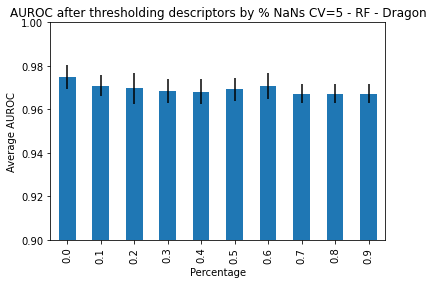

In [21]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, option=3)

It seems to have a very high standard deviation, so let's just go with removing all the columns with missing values

In [22]:
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)
X_train_t_rf, X_val_rf = handleNaNs(X_train_t.copy(), X_val.copy(), option=1)

In [23]:
X_train_rf

,MW,AMW,Sv,Se,Mv,Me,Mp,Mi,GD,nSK,...,s3_numRotBonds,s4_numRotBonds,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_phSize,s34_phRelSize,chiralPhMoment
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.289815,0.045038,0.260541,0.247506,0.247052,0.339609,0.103044,0.359004,0.181818,0.314286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCCCCCCCCCCCCCCCO,0.436307,0.003629,0.595244,0.722982,0.076714,0.124074,0.068637,0.386172,0.117647,0.457143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C1(C(O1)(F)F)(C(F)(F)F)F,0.287677,0.100277,0.154810,0.169345,0.296342,0.840089,0.053488,0.758843,0.222222,0.257143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.233333,0.0,0.0,0.174078
CC(C)(C=C)O,0.132420,0.008764,0.173177,0.210394,0.092541,0.158970,0.069547,0.386769,0.333333,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C=CCC1=CC2=C(C=C1)OCO2,0.280233,0.024984,0.312427,0.306912,0.193245,0.199705,0.103599,0.333724,0.196970,0.314286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.140311,0.013900,0.160319,0.191313,0.092203,0.121267,0.089007,0.369162,0.400000,0.114286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCN(CC)CC,0.161710,0.002373,0.230687,0.294928,0.062509,0.124018,0.062688,0.408251,0.285714,0.171429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.319164,0.026780,0.368109,0.332427,0.229208,0.170217,0.122624,0.300973,0.164835,0.371429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
N,0.019436,0.079126,0.006686,0.005603,0.295056,0.531841,0.086998,0.653212,1.000000,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [24]:
clf.fit(X_train_rf, y_train_rf)
print("Cross validated = 5 performance of Random Forest after removing all columns with NaNs")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Cross validated = 5 performance of Random Forest after removing all columns with NaNs
AVERAGE CV=5 ROC_AUC: 0.9748835291692435
AVERAGE CV=5 STD: 0.005620401674990185


(0.9748835291692435, 0.005620401674990185)

## Using PCA to reduce dimensionality

Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.6156916099773242
AVERAGE CV=5 STD: 0.04121320007826087
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.8503151412079983
AVERAGE CV=5 STD: 0.02012483568567748
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9573812100597815
AVERAGE CV=5 STD: 0.01217683891464918
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.962145176252319
AVERAGE CV=5 STD: 0.015206400211588226
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9671271387342815
AVERAGE CV=5 STD: 0.013980964641017946
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9666081735724592
AVERAGE CV=5 STD: 0.009048656770658045
Validation performance of Random Forest after redu

(0.0, 1.0)

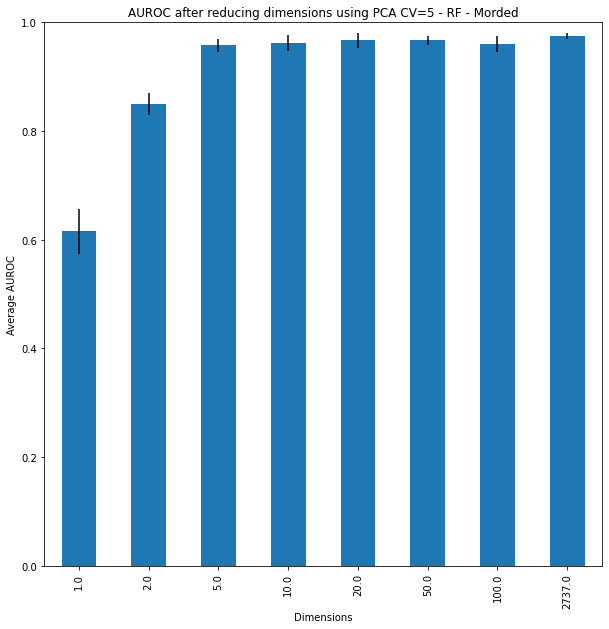

In [25]:
from sklearn import decomposition 

pca_df = pd.DataFrame(columns=['Dimensions', 'Average AUROC', 'Standard Deviation'])

roc_aucs = []
stds = []
pcas = [1, 2, 5, 10, 20, 50, 100]

for n in pcas:
    pca = decomposition.PCA(n_components=n)
    pca_result = pca.fit_transform(X_train_rf)
    clf.fit(pca_result, y_train_rf)
    
    print("Validation performance of Random Forest after reducing dimensionality with PCA")
    roc_auc, std = test_model_cross_val(clf, y_train_rf, pca_result, k=5, verbose=True)
    
    pca_df = pca_df.append({'Dimensions': n, 
                           'Average AUROC':roc_auc, 
                           'Standard Deviation':std}, 
                            ignore_index = True)

clf.fit(X_train_rf, y_train_rf)
print("Validation performance of Random Forest with all dimensions")
roc_auc, std = test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)
roc_aucs.append(roc_auc)
pca_df = pca_df.append({'Dimensions': X_train_rf.shape[-1], 
                       'Average AUROC':roc_auc, 
                       'Standard Deviation':std}, 
                        ignore_index = True)

fig = pca_df.plot(kind="bar", x="Dimensions", y="Average AUROC", ylabel="Average AUROC", 
                   yerr="Standard Deviation", title=f"AUROC after reducing dimensions using PCA CV=5 - RF - Morded", 
                   legend=False, figsize=(10, 10))

plt.ylim(0,1)
        

## Importance experiment

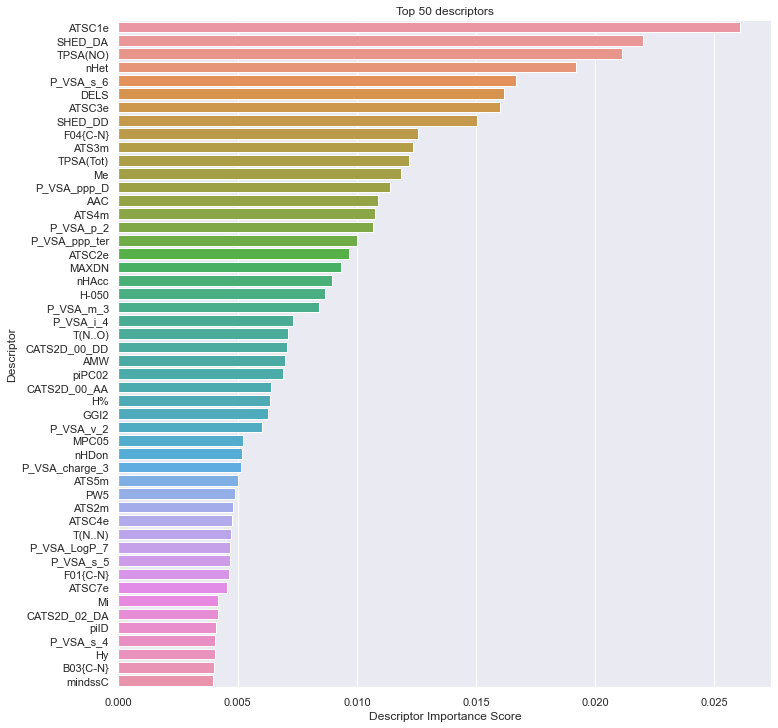

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.839253,0.032477
1,2.0,0.903369,0.032571
2,5.0,0.940006,0.011837
3,10.0,0.962906,0.009724
4,25.0,0.964255,0.008356
5,50.0,0.974330,0.006224
6,100.0,0.973354,0.005624
7,200.0,0.974627,0.002825
8,400.0,0.972644,0.005061
9,2737.0,0.974728,0.005159


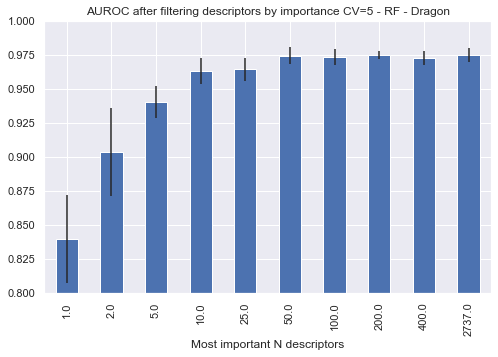

In [26]:
clf.fit(X_train_rf, y_train_rf)
optimiseImportance(clf, X_train_rf, y_train_rf)

AVERAGE CV=5 ROC_AUC: 0.9748835291692435
AVERAGE CV=5 STD: 0.005620401674990185


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.974884,0.005620
1,5.0,0.974482,0.005664
2,10.0,0.974567,0.005243
3,25.0,0.975775,0.004946
4,50.0,0.978090,0.004109
5,100.0,0.974098,0.005658
6,200.0,0.974235,0.006500
7,400.0,0.970350,0.004608


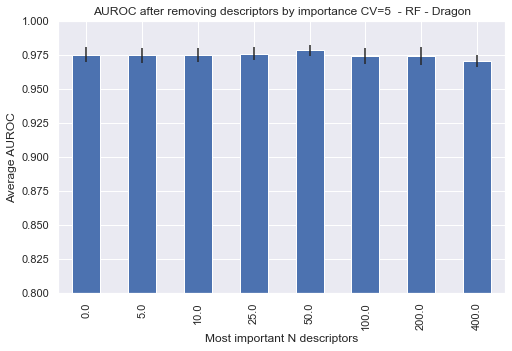

In [27]:
clf.fit(X_train_rf, y_train_rf)
testWithoutImportantDescs(clf, X_train_rf, y_train_rf)

### Remove labels 

In [28]:
clf.fit(X_train_rf, y_train_rf)
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=100)

In [29]:
clf.fit(X_train_rf, y_train_rf)
print("Validation set performance of Random Forest after removing labels")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Validation set performance of Random Forest after removing labels
AVERAGE CV=5 ROC_AUC: 0.9733536899608328
AVERAGE CV=5 STD: 0.00562361298080724


(0.9733536899608328, 0.00562361298080724)

In [30]:
X_train_rf

,ATSC1e,SHED_DA,TPSA(NO),nHet,P_VSA_s_6,DELS,ATSC3e,SHED_DD,F04{C-N},ATS3m,...,F01{C-F},P_VSA_LogP_8,minsF,MPC04,Xindex,B02{F-F},P_VSA_e_3,SssCH2,minssCH2,Mp
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.171284,0.353553,0.527110,0.357143,0.437042,0.222086,0.238702,0.0,0.0625,0.664266,...,0.000000,0.324066,0.000000,0.627632,0.411460,0.0,0.028602,0.098008,0.551434,0.103044
CCCCCCCCCCCCCCCCO,0.057707,0.000000,0.128290,0.071429,0.157321,0.053906,0.088196,0.0,0.0000,0.671234,...,0.000000,0.000000,0.000000,0.562537,0.447635,0.0,0.000000,0.936499,0.668983,0.068637
C1(C(O1)(F)F)(C(F)(F)F)F,0.424925,0.000000,0.079460,0.500000,0.371381,0.365831,0.227703,0.0,0.0000,0.733956,...,0.428571,0.074341,0.787825,0.603923,0.533080,1.0,0.000000,0.098008,0.551434,0.053488
CC(C)(C=C)O,0.024292,0.000000,0.128290,0.071429,0.215435,0.057016,0.080955,0.0,0.0000,0.421047,...,0.000000,0.000000,0.000000,0.000000,0.827132,0.0,0.000000,0.098008,0.551434,0.069547
C=CCC1=CC2=C(C=C1)OCO2,0.005752,0.000000,0.117065,0.142857,0.139200,0.075883,0.044040,0.0,0.0000,0.642687,...,0.000000,0.000000,0.000000,0.717767,0.328654,0.0,0.000000,0.149907,0.658619,0.103599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.015490,0.000000,0.000000,0.071429,0.142137,0.017368,0.018355,0.0,0.0000,0.398430,...,0.000000,0.000000,0.000000,0.147750,0.689547,0.0,0.000000,0.250416,0.878575,0.089007
CCN(CC)CC,0.030893,0.000000,0.020547,0.071429,0.000000,0.017297,0.047670,0.0,0.0000,0.485766,...,0.000000,0.000000,0.000000,0.295500,0.709776,0.0,0.015760,0.250582,0.925622,0.062688
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.009173,0.000000,0.108250,0.071429,0.092679,0.089415,0.030155,0.0,0.0000,0.686720,...,0.000000,0.000000,0.000000,0.717767,0.302547,0.0,0.000000,0.098008,0.551434,0.122624
N,0.000000,0.000000,0.301731,0.142857,0.228053,0.000000,0.000000,0.0,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.312114,0.098008,0.551434,0.086998


## Tuning the hyperparamaters 

In [31]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [32]:
params = {
    'n_estimators': (10, 2000),
    'min_samples_split': (1, 100),
    'max_depth': (3,200),
    'min_samples_leaf': (1, 10)
    }

def rf_hyper_param(n_estimators, 
                       min_samples_split, 
                       max_depth, 
                       min_samples_leaf):

    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    min_samples_split = int(min_samples_split)
    n_estimators = int(n_estimators)

    rf_temp = RandomForestClassifier(
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(rf_temp, X_train_rf, y_train_rf, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=rf_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9625    | 111.1     | 7.437     | 60.67     | 1.094e+03 |
| 2         | 0.9645    | 86.46     | 6.813     | 44.32     | 1.785e+03 |
| 3         | 0.9624    | 192.8     | 4.451     | 79.38     | 1.063e+03 |
| 4         | 0.9656    | 114.9     | 9.33      | 8.033     | 183.4     |
| 5         | 0.9604    | 6.983     | 8.494     | 78.04     | 1.741e+03 |
| 6         | 0.9634    | 91.75     | 7.272     | 45.62     | 1.788e+03 |
| 7         | 0.9676    | 122.1     | 7.925     | 2.02      | 181.9     |
| 8         | 0.9602    | 124.1     | 8.708     | 83.73     | 1.245e+03 |
| 9         | 0.9688    | 120.2     | 5.432     | 3.918     | 189.1     |
| 10        | 0.9715    | 125.2     | 4.887     | 6.646     | 186.3     |
| 11        | 0.9687    | 136.0     | 6.736     | 18.53     | 193.2     |
| 12        | 0.966     | 136.7     | 

In [33]:
params_tuned_rf = optimizer.max['params']
params_tuned_rf['max_depth'] = int(params_tuned_rf['max_depth'])
params_tuned_rf['n_estimators'] = int(params_tuned_rf['n_estimators'])
params_tuned_rf['min_samples_leaf'] = int(params_tuned_rf['min_samples_leaf'])
params_tuned_rf['min_samples_split'] = int(params_tuned_rf['min_samples_split'])

tuned_rf = RandomForestClassifier(**params_tuned_rf, random_state=SEED)
test_model_cross_val(tuned_rf, y_train_rf, X_train_rf, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9738373531230675
AVERAGE CV=5 STD: 0.0064236691997035895


(0.9738373531230675, 0.0064236691997035895)

In [34]:
print(params_tuned_rf)

{'max_depth': 125, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 178}


In [35]:
tuned_rf = RandomForestClassifier(**params_tuned_rf, random_state=SEED)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=125, min_samples_split=12, n_estimators=178,
                       random_state=0)

ROC_AUC (TEST): 0.9821138211382114


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.88      0.90      0.89        50
        True       0.96      0.95      0.96       123

    accuracy                           0.94       173
   macro avg       0.92      0.93      0.92       173
weighted avg       0.94      0.94      0.94       173



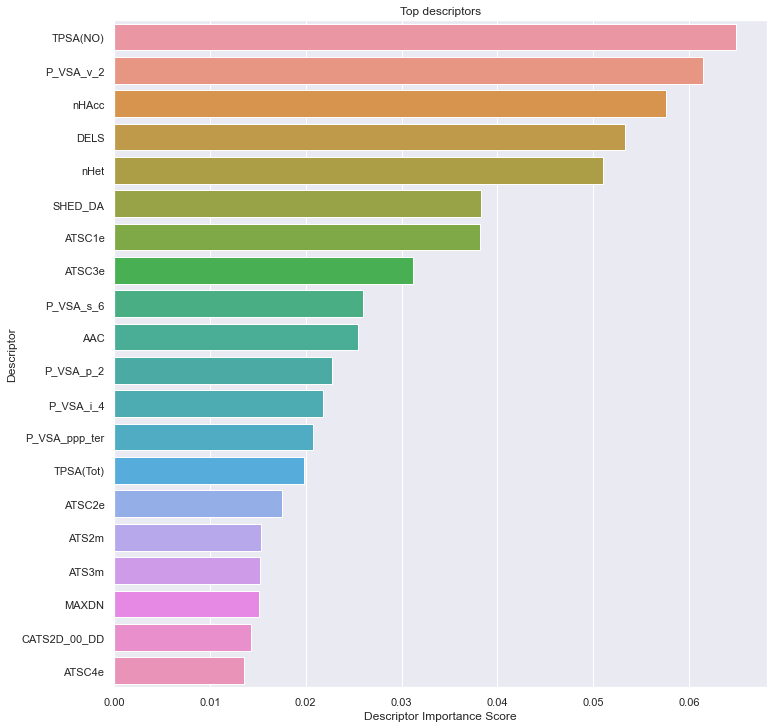

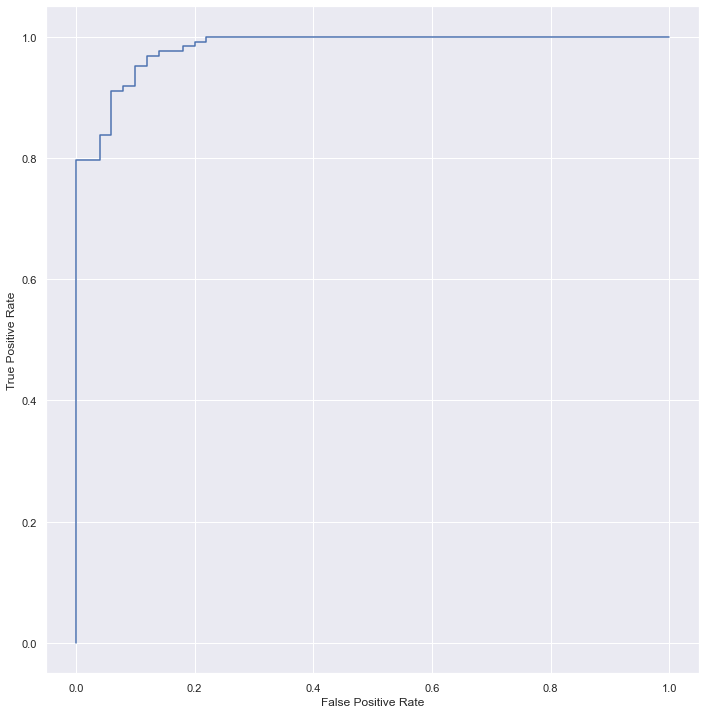

0.9821138211382114

In [36]:
tuned_rf.fit(X_train_rf, y_train_rf)
test_model(tuned_rf, y_test_rf, X_test_rf)

## Extract correlation scores for important features

Extracted correlation scores for most important 100 features for random forest
Printing heatmap for most important 15 features


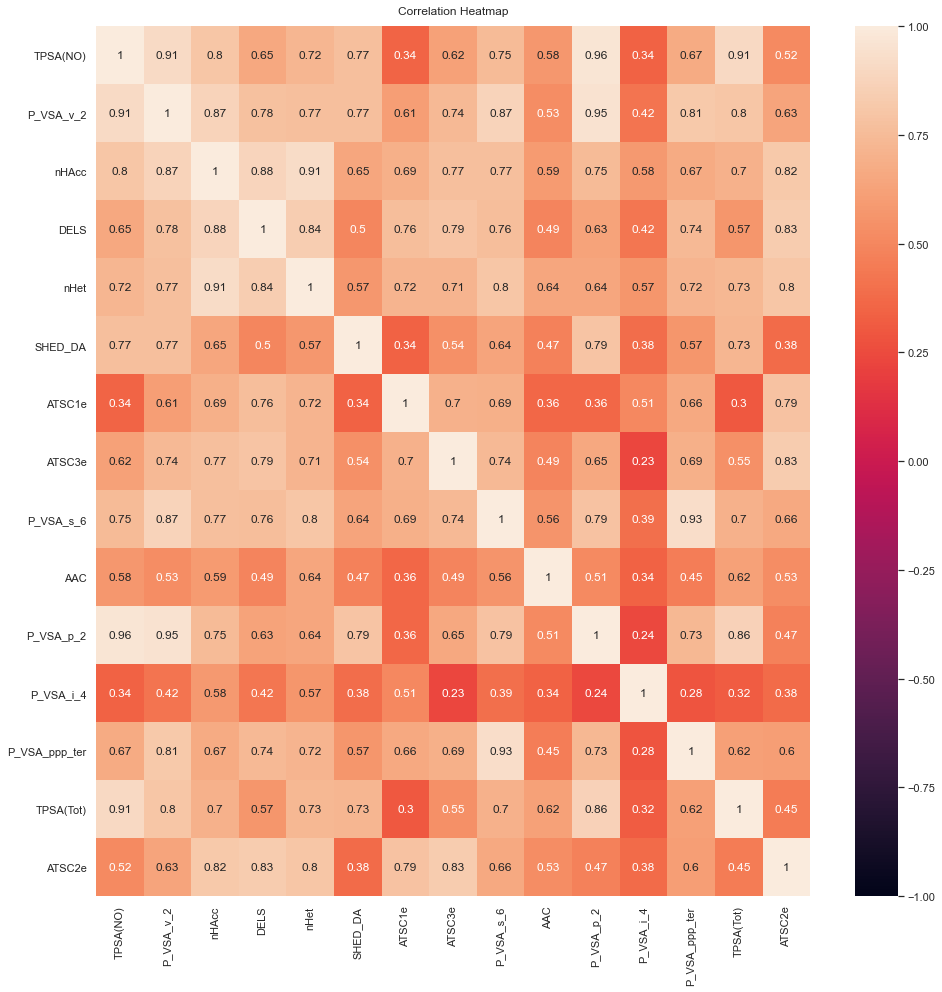

In [37]:
corrs_important_features(tuned_rf, X_test_rf, "random forest", 100, heatmap=15)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with *any* missing values removed

In [38]:
rf_csv = df.loc[:,X_train_rf.columns]
rf_csv.to_csv(f'data/random-forest-df-{dataset}.csv')  
rf_csv

,ATSC1e,SHED_DA,TPSA(NO),nHet,P_VSA_s_6,DELS,ATSC3e,SHED_DD,F04{C-N},ATS3m,...,F01{C-F},P_VSA_LogP_8,minsF,MPC04,Xindex,B02{F-F},P_VSA_e_3,SssCH2,minssCH2,Mp
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.163626,1.649385,74.60,4,135.656540,29.268889,0.641793,1.0,0,3.460840,...,0,0.000000,0.000000,3.663562,0.643904,0,0.000000,0.000000,0.000000,0.689589
C(=C(F)F)(C(F)(F)F)C(F)(F)F,0.642663,0.000000,0.00,8,119.680906,51.030093,0.734472,0.0,0,3.270025,...,8,15.519032,11.130787,3.091042,1.401740,1,0.000000,0.000000,0.000000,0.545467
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],0.264780,3.571652,157.69,10,194.924085,46.596296,0.626771,0.0,3,3.516157,...,0,152.240742,0.000000,3.526361,0.743242,0,17.010153,0.000000,0.000000,0.642032
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.010644,0.000000,32.67,4,81.079101,16.991718,0.215956,0.0,7,3.849487,...,0,39.148644,0.000000,4.025352,0.437844,0,19.909843,0.145860,0.145860,0.724006
C(C(C(F)(F)F)(F)Cl)(F)Cl,0.465056,0.000000,0.00,7,153.097854,34.349537,0.537891,0.0,0,3.966823,...,5,7.759516,11.252778,1.945910,1.435455,1,0.000000,0.000000,0.000000,0.677173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.012223,0.000000,26.30,2,36.144815,9.679019,0.184200,0.0,0,2.399314,...,0,0.000000,0.000000,1.945910,1.047932,0,0.000000,3.073944,0.502527,0.575600
C=CCSS(=O)CC=C,0.037711,0.000000,17.07,3,53.690316,9.490336,0.091026,0.0,0,2.870537,...,0,0.000000,0.000000,1.945910,1.047932,0,0.000000,1.318410,0.567963,0.713521
CCCC(=O)OCC(C)C,0.019560,0.000000,26.30,2,36.144815,10.368409,0.152047,0.0,0,2.599054,...,0,0.000000,0.000000,2.079442,1.048159,0,0.000000,1.974684,0.548333,0.576931
CCCCCOC(=O)CCC,0.026034,0.000000,26.30,2,36.144815,10.724677,0.179834,0.0,0,2.642570,...,0,0.000000,0.000000,2.197225,0.956843,0,0.000000,5.377080,0.561632,0.577986


# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [39]:
# for readibility 
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

## Create model

In [40]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [41]:
# Baseline results
print("Baseline performance of XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Baseline performance of XGBoost
AVERAGE CV=5 ROC_AUC: 0.9695603999175427
AVERAGE CV=5 STD: 0.0033966784988894204


(0.9695603999175427, 0.0033966784988894204)

## Handle NaNs

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.970966,0.005928
1,0.1,0.971088,0.002895
2,0.2,0.970019,0.002457
3,0.3,0.969209,0.002121
4,0.4,0.969362,0.001966
5,0.5,0.966764,0.004098
6,0.6,0.969560,0.003397
7,0.7,0.969560,0.003397
8,0.8,0.969560,0.003397
9,0.9,0.969560,0.003397


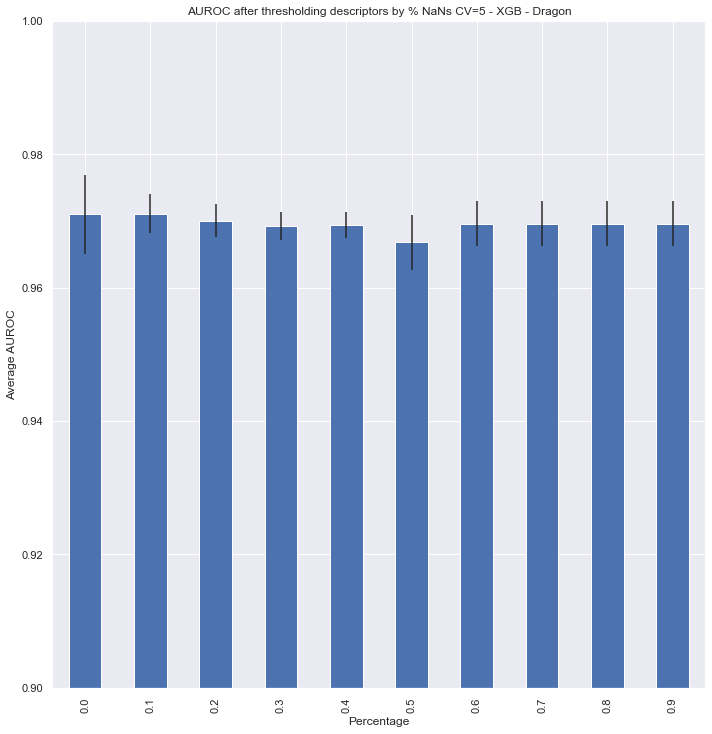

In [42]:
# choose optimal threshold for removing columns with NaNs
#IMPUTING 
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=2, model_name="XGB")

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.970966,0.005928
1,0.1,0.970070,0.004616
2,0.2,0.968938,0.003874
3,0.3,0.970517,0.003590
4,0.4,0.969653,0.003650
5,0.5,0.970164,0.002947
6,0.6,0.970061,0.002891
7,0.7,0.970010,0.002909
8,0.8,0.970010,0.002909
9,0.9,0.970010,0.002909


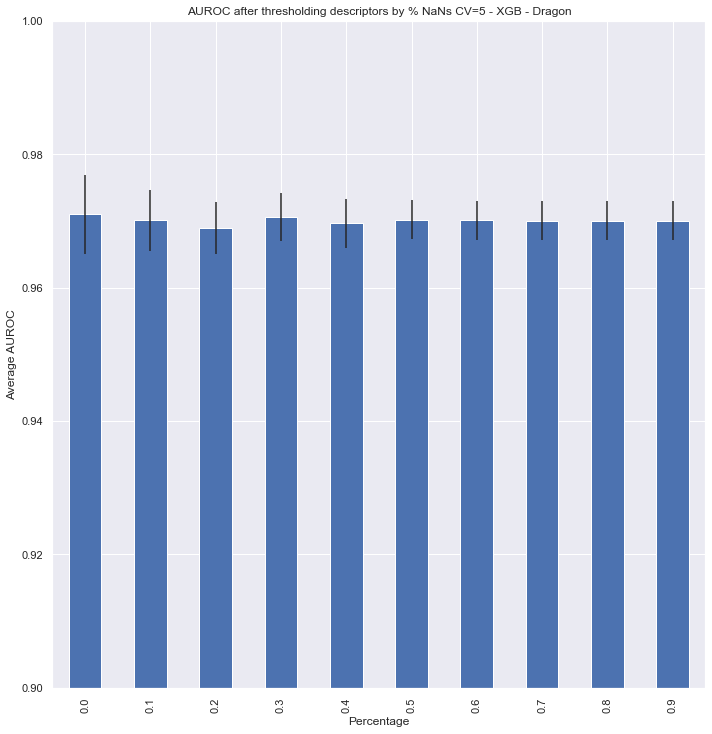

In [43]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=3, model_name="XGB")

In [44]:
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.1)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.1)

In [45]:
xgb.fit(X_train_xgb, y_train_xgb)
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9700695732838591
AVERAGE CV=5 STD: 0.004615586344233545


(0.9700695732838591, 0.004615586344233545)

## Importance Experiment XGB

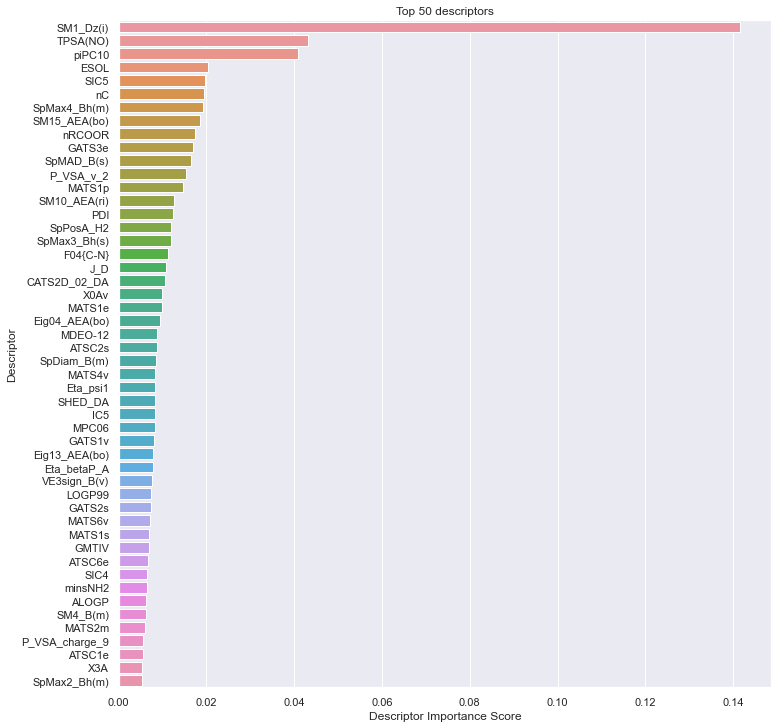

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.917031,0.017075
1,2.0,0.937225,0.012709
2,5.0,0.961775,0.008378
3,10.0,0.967367,0.008967
4,25.0,0.967199,0.005843
5,50.0,0.971890,0.005365
6,100.0,0.976689,0.003422
7,200.0,0.973626,0.001296
8,400.0,0.974847,0.003312
9,3262.0,0.972408,0.003291


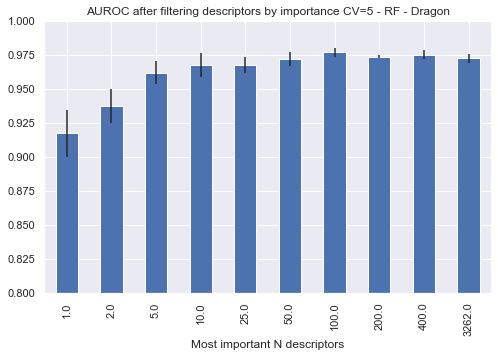

In [46]:
xgb.fit(X_train_xgb, y_train_xgb)
optimiseImportance(xgb, X_train_xgb, y_train_xgb)

AVERAGE CV=5 ROC_AUC: 0.9700695732838591
AVERAGE CV=5 STD: 0.004615586344233545


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.970070,0.004616
1,5.0,0.970422,0.004219
2,10.0,0.970624,0.002296
3,25.0,0.970875,0.003854
4,50.0,0.970824,0.003460
5,100.0,0.964206,0.005515
6,200.0,0.959753,0.006187
7,400.0,0.958330,0.005981


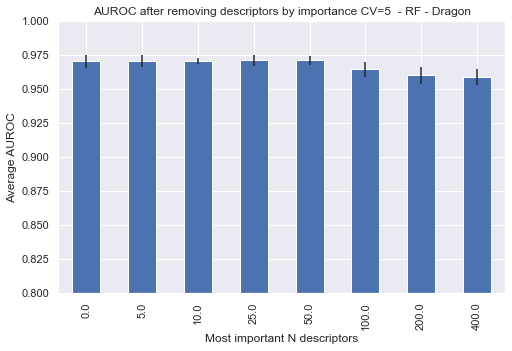

In [47]:
xgb.fit(X_train_xgb, y_train_xgb)
testWithoutImportantDescs(xgb, X_train_xgb, y_train_xgb)

In [48]:
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test=X_test_xgb, 
                                                threshold=-1, 
                                                n=100)

X_train_t_xgb, X_val_xgb, xgb = handle_importance(xgb, 
                                                X_train_t_xgb, 
                                                X_test=X_val_xgb, 
                                                threshold=-1, 
                                                n=100)
xgb.fit(X_train_t_xgb, y_train_t)

# Filted importance results
print("Cross validated CV=5 performance after filtering by importance XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Cross validated CV=5 performance after filtering by importance XGBoost
AVERAGE CV=5 ROC_AUC: 0.9766893424036283
AVERAGE CV=5 STD: 0.0034218120898970505


(0.9766893424036283, 0.0034218120898970505)

In [49]:
X_train_xgb

,SM1_Dz(i),TPSA(NO),piPC10,ESOL,SIC5,nC,SpMax4_Bh(m),SM15_AEA(bo),nRCOOR,GATS3e,...,SpMaxA_AEA(dm),O-060,P_VSA_MR_2,SM3_B(s),SpMin1_Bh(p),ATS3m,SpMin1_Bh(m),Q2,P_VSA_LogP_5,Eta_epsi_5
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.471852,0.527110,0.000000,0.554607,0.856088,0.269231,0.721274,0.238356,0.0,0.281589,...,0.098416,0.0,0.250000,0.715158,0.894078,0.664266,0.856649,0.262474,0.027417,0.403121
CCCCCCCCCCCCCCCCO,0.242697,0.128290,0.202413,0.311740,0.660329,0.615385,0.886242,0.607171,0.0,0.230337,...,0.038658,0.0,0.086771,0.474476,0.854342,0.671234,0.888552,0.126091,0.000000,0.221643
C1(C(O1)(F)F)(C(F)(F)F)F,0.724321,0.079460,0.000000,0.541786,0.296658,0.115385,0.424445,0.238356,0.0,0.323272,...,0.154708,0.0,0.330838,0.848432,0.705013,0.733956,0.528121,0.370919,0.414144,0.831997
CC(C)(C=C)O,0.242697,0.128290,0.000000,0.681688,0.288910,0.192308,0.575733,0.476712,0.0,0.764798,...,0.219257,0.0,0.260314,0.438938,0.810663,0.421047,0.827027,0.105854,0.000000,0.248597
C=CCC1=CC2=C(C=C1)OCO2,0.306878,0.117065,0.345379,0.498267,0.938843,0.384615,0.734206,0.400650,0.0,0.287107,...,0.079702,0.4,0.081086,0.447264,0.850582,0.642687,0.857566,0.275792,0.164587,0.312082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.129394,0.000000,0.000000,0.615808,0.517274,0.153846,0.474306,0.476712,0.0,0.279281,...,0.256920,0.0,0.086771,0.202073,0.792533,0.398430,0.831029,0.027282,0.000000,0.185779
CCN(CC)CC,0.262960,0.020547,0.000000,0.653636,0.320830,0.230769,0.609328,0.476712,0.0,0.733710,...,0.143857,0.0,0.390471,0.223375,0.831710,0.485766,0.838315,0.053978,0.014415,0.252606
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.242697,0.108250,0.557940,0.384177,0.654668,0.500000,0.721274,0.636145,0.0,0.302894,...,0.074563,0.0,0.092679,0.566325,0.874090,0.686720,0.878848,0.089146,0.029396,0.250601
N,0.341642,0.301731,0.000000,0.850630,0.000000,0.000000,0.000000,0.476712,0.0,0.000000,...,0.000000,0.0,0.000000,0.516111,0.517979,0.000000,0.283619,0.000000,0.285477,0.541299


## Tuning paramaters 

In [50]:
params = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
#    'subsample': (0.7, 1.0),  # Change for big datasets
    'colsample_bytree': (0.7, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5), 
    'reg_lambda': (0, 2),
    'reg_alpha':(0, 2),
    'scale_pos_weight': (1, 2.5)
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        colsample_bytree,
                        gamma, 
                        reg_lambda, 
                        reg_alpha,
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    xgb_temp = XGBClassifier(
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        reg_lambda=reg_lambda, 
        reg_alpha=reg_alpha,
        scale_pos_weight=scale_pos_weight,
        seed=SEED)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(xgb_temp, X_train_xgb, y_train_xgb, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=xgboost_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=30)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | scale_... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9652    | 0.8646    | 3.576     | 0.6067    | 6.814     | 481.3     | 1.292     | 0.8752    | 2.338     |
| 2         | 0.969     | 0.9891    | 1.917     | 0.7938    | 6.702     | 611.2     | 1.851     | 0.1421    | 1.131     |
| 3         | 0.9681    | 0.7061    | 4.163     | 0.7804    | 9.09      | 980.8     | 1.598     | 0.923     | 2.171     |
| 4         | 0.9749    | 0.7355    | 3.2       | 0.1519    | 9.613     | 569.7     | 0.8293    | 0.5291    | 2.161     |
| 5         | 0.9739    | 0.8368    | 2.842     | 0.0286    | 7.323     | 650.9     | 1.234     | 1.887     | 2.023     |
| 6         | 0.9727    | 0.9245    | 4.506     | 0.1645    | 9.11      | 569.6     | 0.5934    | 0.02827   | 2.255     |
| 7         | 0.9732    

In [51]:
params_tuned_xgb = optimizer.max['params']
params_tuned_xgb['max_depth'] = int(params_tuned_xgb['max_depth'])
params_tuned_xgb['n_estimators'] = int(params_tuned_xgb['n_estimators'])
print(params_tuned_xgb)

tuned_xgb = XGBClassifier(**params_tuned_xgb, seed=SEED)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

{'colsample_bytree': 0.7354823277606799, 'gamma': 3.199605106637619, 'learning_rate': 0.15191975453495596, 'max_depth': 9, 'n_estimators': 569, 'reg_alpha': 0.8293238799810472, 'reg_lambda': 0.5291112242092539, 'scale_pos_weight': 2.161350534151325}
AVERAGE CV=5 ROC_AUC: 0.9743127705627705
AVERAGE CV=5 STD: 0.005877808945725796


(0.9743127705627705, 0.005877808945725796)

### Final tuned paramaters


In [52]:
# params = {'colsample_bytree': 0.8169037217345981, 'gamma': 0.6914223828184318, 'learning_rate': 0.03485637608005026, 'max_depth': 7, 'n_estimators': 759, 'reg_alpha': 1.342353161174468, 'reg_lambda': 0.7006577350782055, 'scale_pos_weight': 2.354475267911879}
# tuned_xgb = XGBClassifier(**params,
#                           seed=SEED,  
#                           n_jobs = -1)

print("Final tuned CV performance for XGB")
tuned_xgb.fit(X_train_xgb, y_train)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Final tuned CV performance for XGB
AVERAGE CV=5 ROC_AUC: 0.9743127705627705
AVERAGE CV=5 STD: 0.005877808945725796


(0.9743127705627705, 0.005877808945725796)

ROC_AUC (TEST): 0.9762601626016261


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.94      0.88      0.91        50
        True       0.95      0.98      0.96       123

    accuracy                           0.95       173
   macro avg       0.94      0.93      0.94       173
weighted avg       0.95      0.95      0.95       173



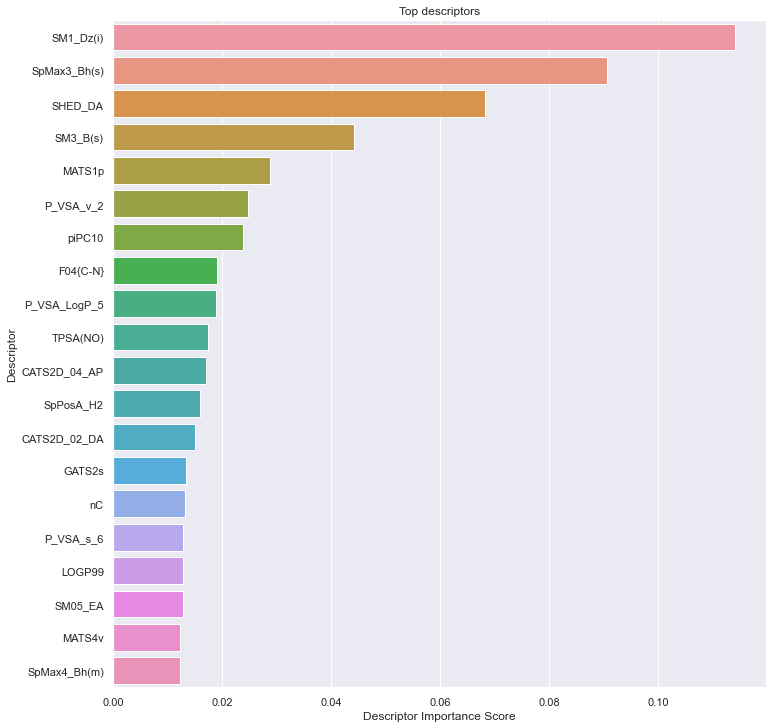

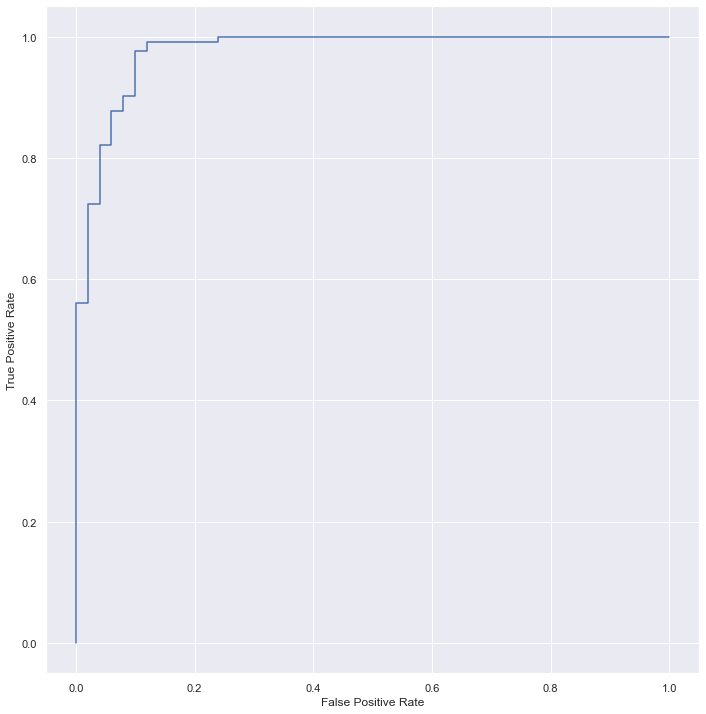

0.9762601626016261

In [53]:
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

## Extract correlation for 'important' features

Extracted correlation scores for most important 100 features for xgb
Printing heatmap for most important 15 features


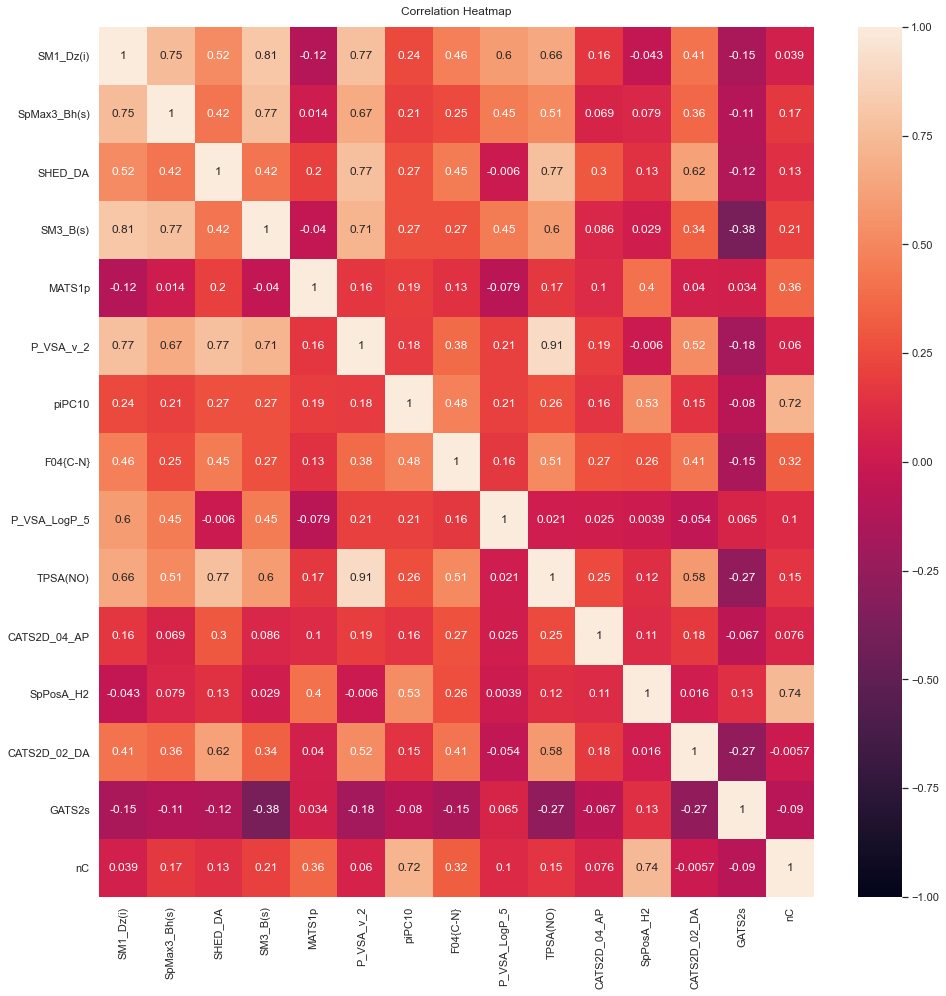

In [54]:
corrs_important_features(tuned_xgb, X_test_xgb, "xgb", 100, 15)

## Save dataframe used in XGB to CSV

In [55]:
rf_csv = df.loc[:,X_train_xgb.columns]
rf_csv.to_csv(f'data/xgb-df-{dataset}.csv')  
rf_csv

,SM1_Dz(i),TPSA(NO),piPC10,ESOL,SIC5,nC,SpMax4_Bh(m),SM15_AEA(bo),nRCOOR,GATS3e,...,SpMaxA_AEA(dm),O-060,P_VSA_MR_2,SM3_B(s),SpMin1_Bh(p),ATS3m,SpMin1_Bh(m),Q2,P_VSA_LogP_5,Eta_epsi_5
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.526148,74.60,4.123094,-1.444735,0.776981,9,2.646345,-0.584664,0,0.757910,...,0.318201,0,50.289854,7.301830,1.958558,3.460840,1.985892,0.727261,6.371150,0.851111
C(=C(F)F)(C(F)(F)F)C(F)(F)F,1.342760,0.00,0.000000,-3.401652,0.000000,4,1.581000,-1.000000,0,2.062500,...,0.428076,0,89.760680,8.393770,1.848830,3.270025,1.552529,0.709677,137.922942,1.442857
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],1.060322,157.69,0.000000,-2.540350,0.776981,6,3.118747,0.000000,0,1.024344,...,0.243057,0,42.683343,7.959278,2.170518,3.516157,1.987733,0.560423,8.270243,1.062745
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.562583,32.67,7.092158,-4.183530,0.911363,16,3.191691,1.073829,0,1.021933,...,0.171406,0,25.144927,6.850126,2.031832,3.849487,2.045865,0.406049,29.414034,0.812619
C(C(C(F)(F)F)(F)Cl)(F)Cl,1.109189,0.00,0.000000,-3.331275,0.000000,3,2.260189,-1.000000,0,0.816514,...,0.523179,0,74.800566,7.982419,1.767601,3.966823,1.457743,0.547269,74.800566,1.394286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.297286,26.30,0.000000,-1.588033,0.831705,7,2.552583,-1.573405,1,1.262643,...,0.460092,1,71.458121,6.335205,1.909060,2.399314,1.977178,0.412530,10.999888,0.870370
C=CCSS(=O)CC=C,-0.000700,17.07,0.000000,-1.568990,0.900880,6,2.750770,-1.573405,0,1.279842,...,0.511858,0,22.156476,6.401043,1.752398,2.870537,1.799928,0.133031,0.000000,0.844444
CCCC(=O)OCC(C)C,0.297286,26.30,0.000000,-1.895756,0.768723,8,2.536516,-1.000000,1,1.146202,...,0.409208,1,47.915917,6.366624,1.918943,2.599054,1.972379,0.417394,10.999888,0.853333
CCCCCOC(=O)CCC,0.297286,26.30,0.000000,-2.114099,0.847320,9,2.922625,-0.772951,1,1.112999,...,0.368121,1,59.687019,6.378168,1.925612,2.642570,1.997519,0.421929,10.999888,0.839394


# Compare descriptors used by both models 

In [56]:
len(set(X_train_rf.columns) - set(X_train_xgb.columns))

81

In [57]:
len(set(X_train_xgb.columns) - set(X_train_rf.columns))

81

# Keras

https://www.pluralsight.com/guides/classification-keras

In [58]:
!pip install keras
!pip install scikeras

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# for readibility 
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()

tf.random.set_seed(SEED)


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Preprocessing

### Handle NaNs 
- You can't have missing values in a Neural Network, so we choose to remove all columns with them (for now)

In [59]:
X_train_nn, X_test_nn = handleNaNs(X_train.copy(), X_test.copy(), option=1)
X_train_t_nn, X_val_nn = handleNaNs(X_train_t.copy(), X_val.copy(), option=1)

In [60]:
X_train_nn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692 entries, C1=CC(=CC=C1C(=O)O)[N+](=O)[O-] to CC(C)N
Columns: 2737 entries, MW to chiralPhMoment
dtypes: float64(2737)
memory usage: 14.5+ MB


## Prepare a validation set
- Stratified 

In [61]:
y_train_t_nn, y_val_nn = y_train_t.copy(), y_val.copy()

### Encode class values as integers

Use adam optimizer so we don't have to specify learning rate, as is the case with gradient descent, and optimise for it

In [62]:
encoder = LabelEncoder()
encoder.fit(y_train_nn)
y_train_nn = encoder.transform(y_train_nn)
y_train_t_nn = encoder.transform(y_train_t_nn)
y_test_nn = encoder.transform(y_test_nn)
y_val_nn = encoder.transform(y_val_nn)

## Metrics

## Test model - Keras

In [63]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc', curve='ROC'),
]

In [64]:
def test_model_keras(model, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn): 
    # Plot training and validation auc 

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model roc_auc')
    plt.ylabel('ROC_AUC')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # Plot training and validation ROC curve

    y_pred_keras = model.predict(X_val_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_nn, y_pred_keras)
    auc_v_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)

    y_pred_t_keras = model.predict(X_train_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_train_nn, y_pred_t_keras)

    plt.plot(fpr_keras, tpr_keras)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Validation (area = {:.3f})'.format(auc_v_keras), 'Training (area = {:.3f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()


## Baseline Single Layer model
- Overfitting quite a bit, you can see it when you compare the validation set auc and the auc for the training set 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2738)              7496644   
                                                                 
 dense_1 (Dense)             (None, 1)                 2739      
                                                                 
Total params: 7,499,383
Trainable params: 7,499,383
Non-trainable params: 0
_________________________________________________________________


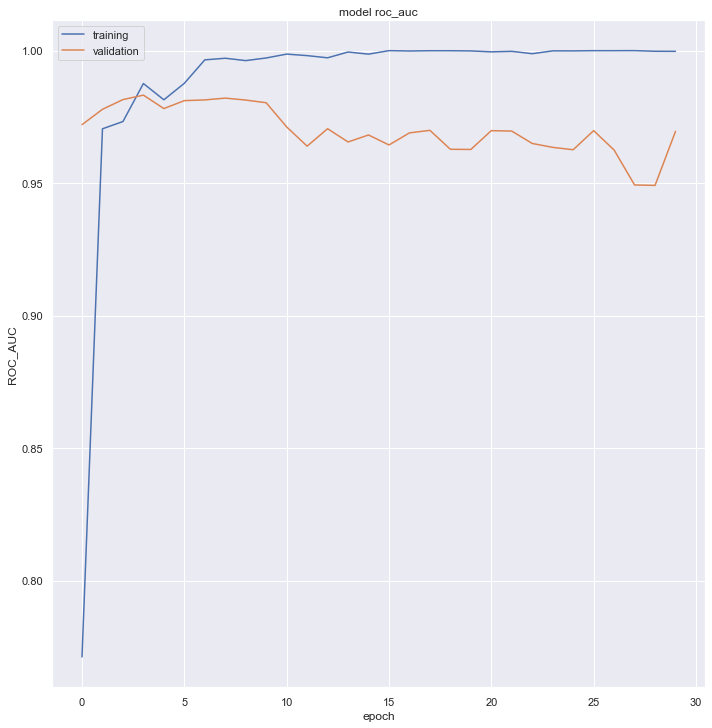

16/16 [==============================] - 0s 7ms/step


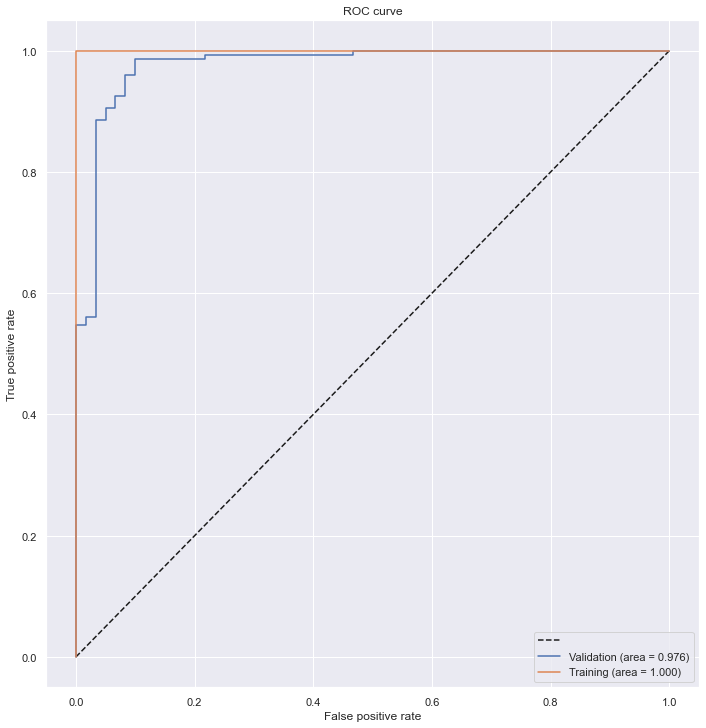

In [65]:
model = keras.Sequential()
model.add(keras.layers.Dense(X_train_nn.shape[-1]+1, activation="relu", input_shape=(X_train_nn.shape[-1],)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30, 
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

## Tuning Multi Layer model

In [66]:
def model_builder(hp):

    model = keras.Sequential()
    model.add(Dense(X_train_t_nn.shape[-1], input_shape=(X_train_t_nn.shape[-1],), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=500, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=800, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

### Instantiate the tuner and perform hypertuning

https://www.tensorflow.org/tutorials/keras/keras_tuner The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer. Create a callback to stop training early after reaching a certain value for the validation loss.



To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [67]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir",
                     project_name="odor",
                     overwrite=True,)

tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=30,
             validation_data=(X_val_nn, y_val_nn),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 04s]
val_auc: 0.9655405282974243

Best val_auc So Far: 0.9785473346710205
Total elapsed time: 00h 01m 50s
INFO:tensorflow:Oracle triggered exit


In [68]:
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 182 
 The optimal number of units in the second densely-connected
layer is 402 
 The optimal number of dropouts in the first densely-connected
layer is 0.30000000000000004.
 The optimal learning 
rate is  0.001



In [69]:
model3 = tuner.hypermodel.build(best_hps)
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2737)              7493906   
                                                                 
 dense_5 (Dense)             (None, 182)               498316    
                                                                 
 dropout_1 (Dropout)         (None, 182)               0         
                                                                 
 dense_6 (Dense)             (None, 402)               73566     
                                                                 
 dense_7 (Dense)             (None, 1)                 403       
                                                                 
Total params: 8,066,191
Trainable params: 8,066,191
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
16/16 [==============================] - 2s 83ms/step - loss: 0.4603 - tp: 445.0000 - fp: 88.0000 - tn: 112.0000 - fn: 47.0000 - precision: 0.8349 - recall: 0.9045 - auc: 0.8578 - val_loss: 0.2104 - val_tp: 142.0000 - val_fp: 11.0000 - val_tn: 49.0000 - val_fn: 6.0000 - val_precision: 0.9281 - val_recall: 0.9595 - val_auc: 0.9710
Epoch 2/30
16/16 [==============================] - 1s 63ms/step - loss: 0.2095 - tp: 330.0000 - fp: 26.0000 - tn: 114.0000 - fn: 14.0000 - precision: 0.9270 - recall: 0.9593 - auc: 0.9668 - val_loss: 0.1947 - val_tp: 142.0000 - val_fp: 11.0000 - val_tn: 49.0000 - val_fn: 6.0000 - val_precision: 0.9281 - val_recall: 0.9595 - val_auc: 0.9722
Epoch 3/30
16/16 [==============================] - 1s 62ms/step - loss: 0.2166 - tp: 327.0000 - fp: 28.0000 - tn: 112.0000 - fn: 17.0000 - precision: 0.9211 - recall: 0.9506 - auc: 0.9643 - val_loss: 0.1741 - val_tp: 139.0000 - val_fp: 5.0000 - val_tn: 55.0000 - val_fn: 9.0000 - val_precision: 0.9653 - val_recal

Epoch 25/30
16/16 [==============================] - 1s 62ms/step - loss: 0.0111 - tp: 343.0000 - fp: 1.0000 - tn: 139.0000 - fn: 1.0000 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - val_loss: 0.3416 - val_tp: 141.0000 - val_fp: 5.0000 - val_tn: 55.0000 - val_fn: 7.0000 - val_precision: 0.9658 - val_recall: 0.9527 - val_auc: 0.9635
Epoch 26/30
16/16 [==============================] - 1s 62ms/step - loss: 0.0158 - tp: 342.0000 - fp: 2.0000 - tn: 138.0000 - fn: 2.0000 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - val_loss: 0.3494 - val_tp: 142.0000 - val_fp: 5.0000 - val_tn: 55.0000 - val_fn: 6.0000 - val_precision: 0.9660 - val_recall: 0.9595 - val_auc: 0.9629
Epoch 27/30
16/16 [==============================] - 1s 61ms/step - loss: 0.0071 - tp: 344.0000 - fp: 1.0000 - tn: 139.0000 - fn: 0.0000e+00 - precision: 0.9971 - recall: 1.0000 - auc: 0.9999 - val_loss: 0.3453 - val_tp: 142.0000 - val_fp: 5.0000 - val_tn: 55.0000 - val_fn: 6.0000 - val_precision: 0.9660 - val_recall

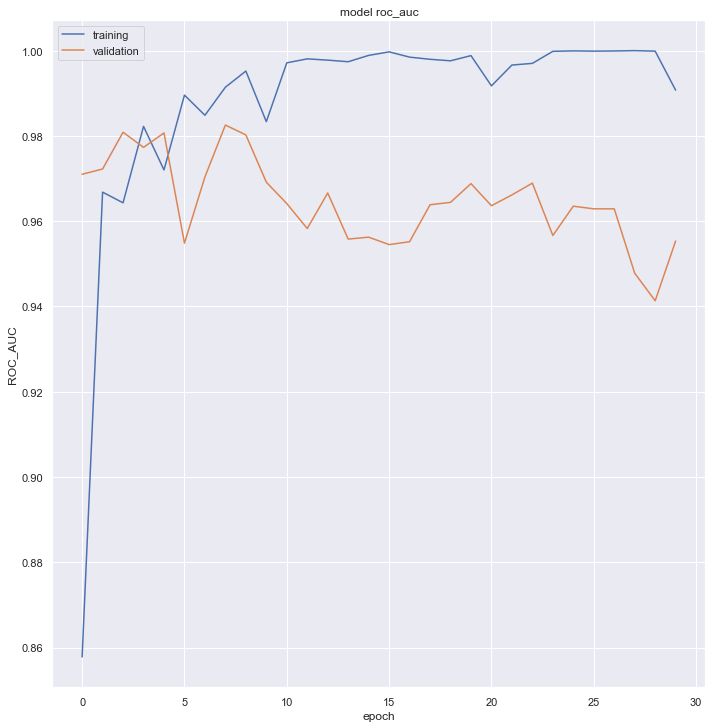

16/16 [==============================] - 0s 7ms/step


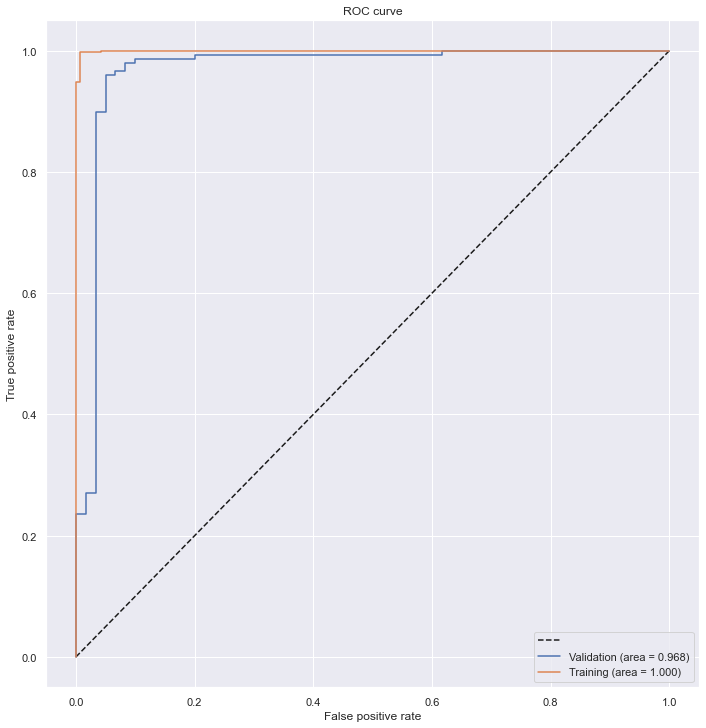

In [70]:
# Build the model with the optimal hyperparameters 
history = model3.fit( X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30, 
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=1)

test_model_keras(model3, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

## Feature selection 

Using the set of the top 100 descriptors from RF and XGB, filter the dataset by these descriptors, and then measure validation accuracy

In [71]:
def model_builder_2(hp):

    model = keras.Sequential()
    model.add(Dense((X_train_t_nn_temp.shape[-1]), input_shape=((X_train_t_nn_temp.shape[-1]),), activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_3', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

### Use different algorithms for feature ranking

In [72]:
import sklearn.feature_selection as fs
from sklearn.svm import LinearSVC
import random

ranking = []
algos = ['random', 'rf', 'f_classif', 'mutual_info_classif']
ks = [5, 50, 100, 400, X_train_t_nn.shape[-1]]

accuracy_2 = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
  print(algo)
  
  for k in ks:
        print(k)

        X_train_t_nn_temp = X_train_t_nn.copy()
        X_val_nn_temp = X_val_nn.copy()
        
        if algo == 'random':
            indexes = list(range(X_train_t_nn.shape[-1]))
            random.shuffle(indexes)
            top_n = indexes[0:k]
            X_train_t_nn_temp = X_train_t_nn.iloc[:,top_n]
            X_val_nn_temp = X_val_nn.iloc[:,top_n]
        else:
            if algo == 'f_classif': 
                bk = fs.SelectKBest(fs.f_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == "mutual_info_classif":
                bk = fs.SelectKBest(fs.mutual_info_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == 'rf':
                tuned_rf.fit(X_train_t_nn_temp, y_train_t_nn)
                bk = fs.SelectFromModel(tuned_rf, prefit=True, max_features=k)
                
            X_train_t_nn_temp = bk.transform(X_train_t_nn)
            X_val_nn_temp = bk.transform(X_val_nn_temp)

        tuner = kt.Hyperband(model_builder_2,
                             objective=kt.Objective("val_auc", direction="max"),
                             max_epochs=10,
                             factor=3,
                             seed=SEED, 
                             directory="results_dir",
                             project_name="odor",
                             overwrite=True,)

        tuner.search(X_train_t_nn_temp, 
                     y_train_t_nn, 
                     epochs=30,
                     validation_data=(X_val_nn_temp, y_val_nn),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

        # Get the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  
        model_temp = tuner.hypermodel.build(best_hps)
        model_temp.summary()

        history = model_temp.fit(X_train_t_nn_temp, 
                             y_train_t_nn, 
                             epochs=30, 
                             validation_data=(X_val_nn_temp, y_val_nn), 
                             verbose=0)

        y_pred_keras = model_temp.predict(X_val_nn_temp).ravel()
        auc_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)
        accuracy_2.loc[k, algo] = auc_keras
        
        
accuracy_2

Trial 30 Complete [00h 00m 05s]
val_auc: 0.5083333253860474

Best val_auc So Far: 0.9779842495918274
Total elapsed time: 00h 02m 31s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2737)              7493906   
                                                                 
 dense_6 (Dense)             (None, 1832)              5016016   
                                                                 
 dropout_1 (Dropout)         (None, 1832)              0         
                                                                 
 dense_7 (Dense)             (None, 1212)              2221596   
                                                                 
 dense_8 (Dense)             (None, 472)               572536    
                                                                 
 dense_9 (Dense

,random,rf,f_classif,mutual_info_classif
5,0.5,0.949775,0.926689,0.93857
50,0.901914,0.957827,0.95152,0.958277
100,0.942342,0.972523,0.968243,0.957545
400,0.96982,0.965203,0.969595,0.967793
2737,0.974437,0.971509,0.96875,0.96205


Text(0, 0.5, 'ROC_AUC')

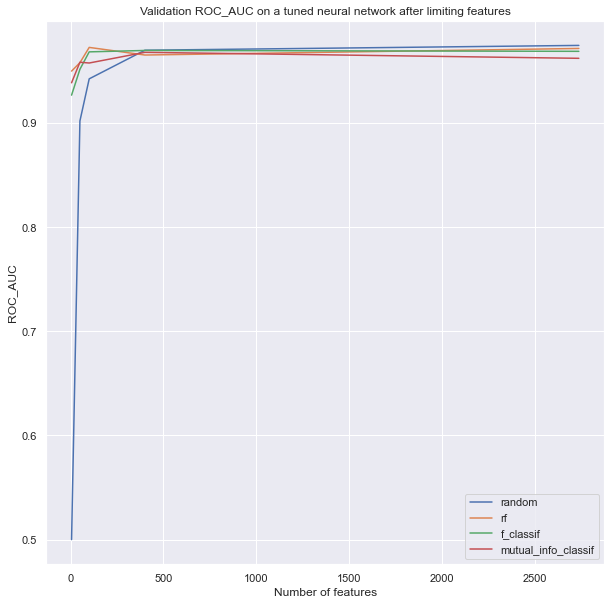

In [73]:
ax = accuracy_2.plot(figsize=(10, 10))
ax.set_title("Validation ROC_AUC on a tuned neural network after limiting features")
ax.set_xlabel("Number of features")
ax.set_ylabel("ROC_AUC")

Choose f_classif method of feature selection, with 100 features.
### Retune and retrain model

In [74]:
def model_builder_3(hp):

    model = keras.Sequential()
    model.add(Dense(100, input_shape=(100,), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

In [75]:
import sklearn.feature_selection as fs
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train_nn)
X_train_nn = constant_filter.transform(X_train_nn)
X_test_nn = constant_filter.transform(X_test_nn)
X_val_nn = constant_filter.transform(X_val_nn)
X_train_t_nn = constant_filter.transform(X_train_t_nn)


    
bk = fs.SelectKBest(fs.f_classif, k=100)
bk.fit(X_train_nn, y_train_nn)
X_train_nn = bk.transform(X_train_nn)

In [76]:
X_val_nn = bk.transform(X_val_nn)

In [77]:
X_test_nn = bk.transform(X_test_nn)

In [78]:
X_train_t_nn = bk.transform(X_train_t_nn)

In [79]:
print(X_val_nn.shape)
tuner = kt.Hyperband(model_builder_3,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir",
                     project_name="odor",
                     overwrite=True,)
                     
tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=30,
             validation_data=(X_val_nn, y_val_nn),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

Trial 30 Complete [00h 00m 02s]
val_auc: 0.9503377676010132

Best val_auc So Far: 0.973423421382904
Total elapsed time: 00h 01m 07s
INFO:tensorflow:Oracle triggered exit


In [80]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 1512 
 The optimal number of units in the second densely-connected
layer is 892 
 The optimal number of dropouts in the first densely-connected
layer is 0.0.
 The optimal learning 
rate is  0.001



In [81]:
model4 = tuner.hypermodel.build(best_hps)
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1512)              152712    
                                                                 
 dropout_1 (Dropout)         (None, 1512)              0         
                                                                 
 dense_6 (Dense)             (None, 892)               1349596   
                                                                 
 dense_7 (Dense)             (None, 1)                 893       
                                                                 
Total params: 1,513,301
Trainable params: 1,513,301
Non-trainable params: 0
_________________________________________________________________


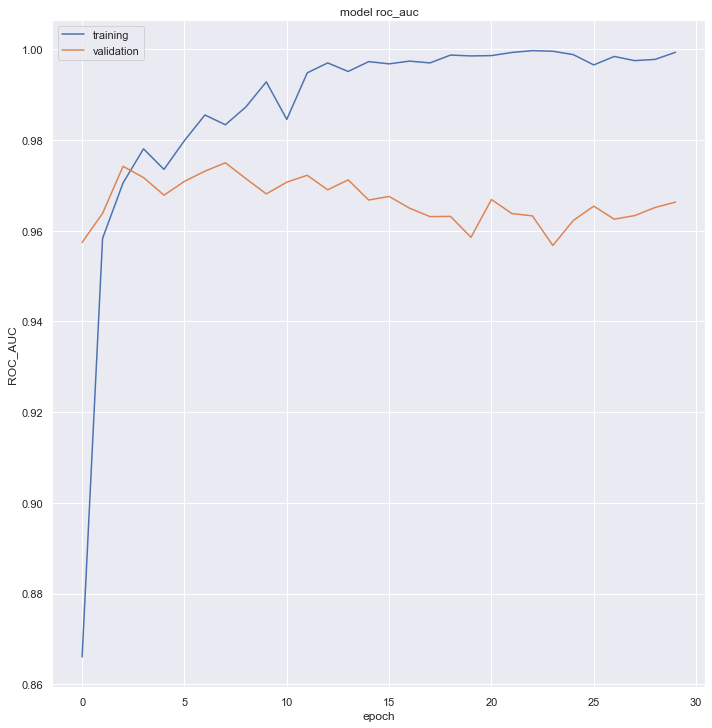

22/22 [==============================] - 0s 2ms/step


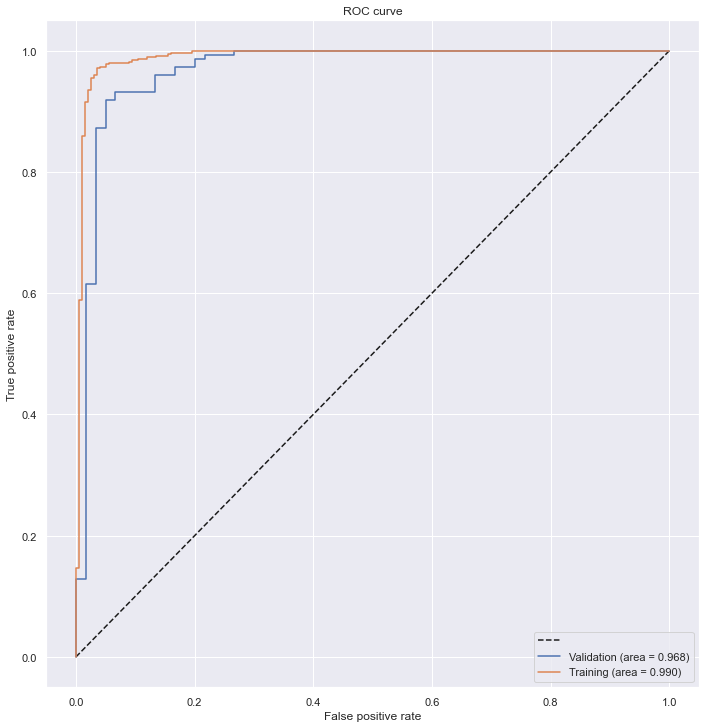

In [82]:
history = model4.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

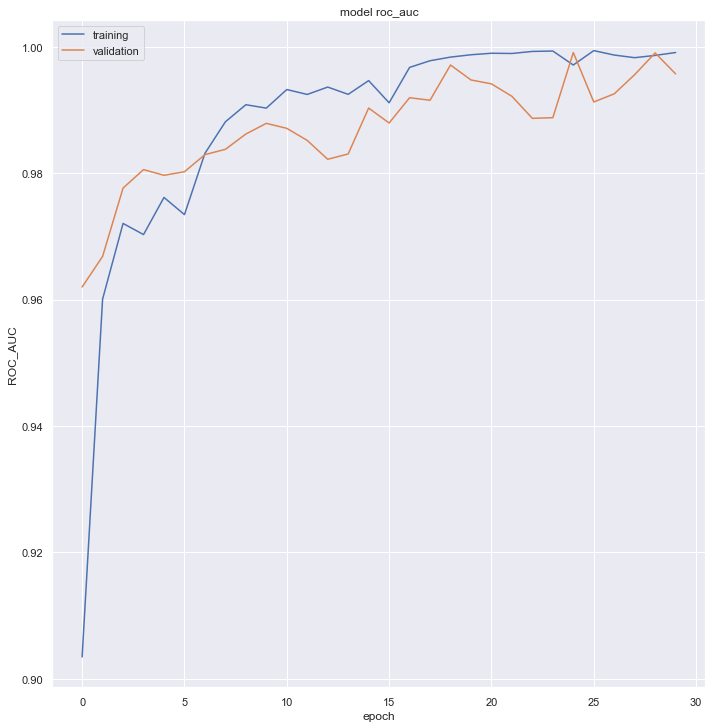

22/22 [==============================] - 0s 2ms/step


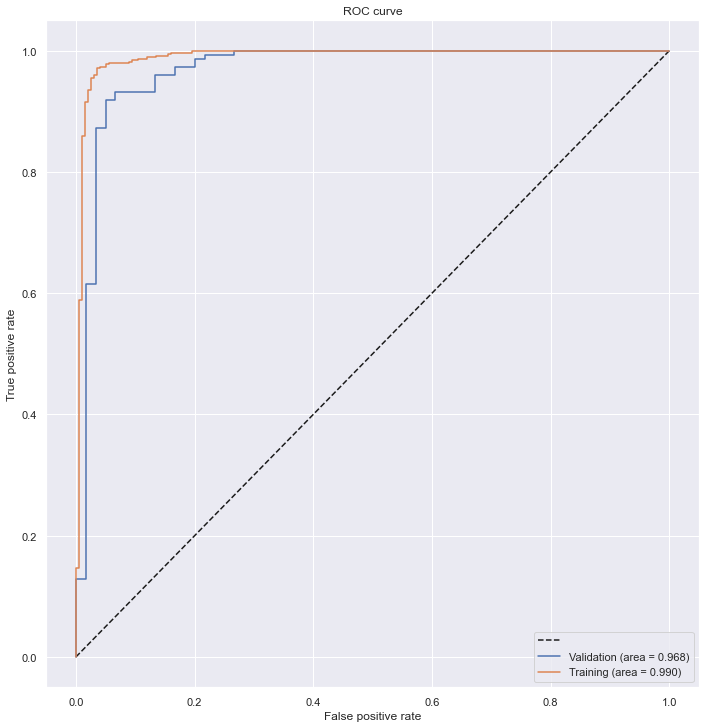

In [83]:
model_final = tuner.hypermodel.build(best_hps)

# Build the final model with all the training data with the optimal hyperparameters 
history = model_final.fit(X_train_nn, 
                      y_train_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

## Evaluate model on test data

6/6 [==============================] - 0s 2ms/step


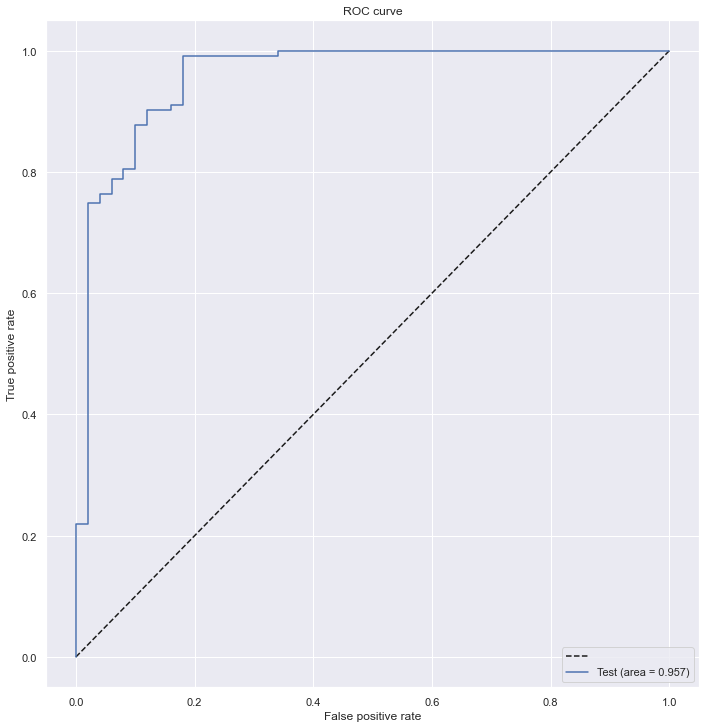

In [84]:
y_pred_t_keras = model_final.predict(X_test_nn).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)
auc_t_keras

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(['', 'Test (area = {:.3f})'.format(auc_t_keras)], loc='best')
plt.show()
plt.show()

# Penalized SVM

In [85]:
from sklearn import svm

y_train_svm = y_train.copy()
y_test_svm = y_test.copy()
X_train_svm, X_test_svm = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [86]:
clf_s = svm.SVC(kernel='linear',
                gamma='scale',
                class_weight='balanced', # penalize
                probability=True)

In [87]:
from sklearn.model_selection import RepeatedStratifiedKFold

print("Baseline CV=10 training performance of a SVM")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_svm, y_train_svm, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Baseline CV=10 training performance of a SVM
Mean ROC AUC: 0.978


In [88]:
print("CV=5 training performance of a SVM with RF most important descriptors")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_rf, y_train_rf, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

CV=5 training performance of a SVM with RF most important descriptors
Mean ROC AUC: 0.973


ROC_AUC (TEST): 0.9544715447154473


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.79      0.92      0.85        50
        True       0.97      0.90      0.93       123

    accuracy                           0.91       173
   macro avg       0.88      0.91      0.89       173
weighted avg       0.92      0.91      0.91       173



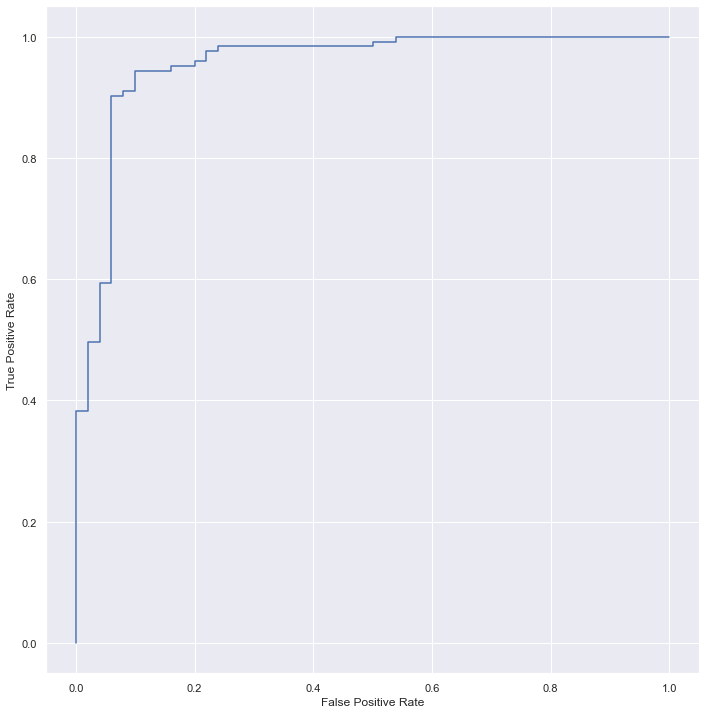

0.9544715447154473

In [89]:
clf_s.fit(X_train_rf, y_train_rf)
test_model(clf_s, y_test_rf, X_test_rf)